# Entity Extraction with Claude

> *This notebook should work well with the **`Python 3`** kernel in SageMaker Studio*

### Choosing an approach

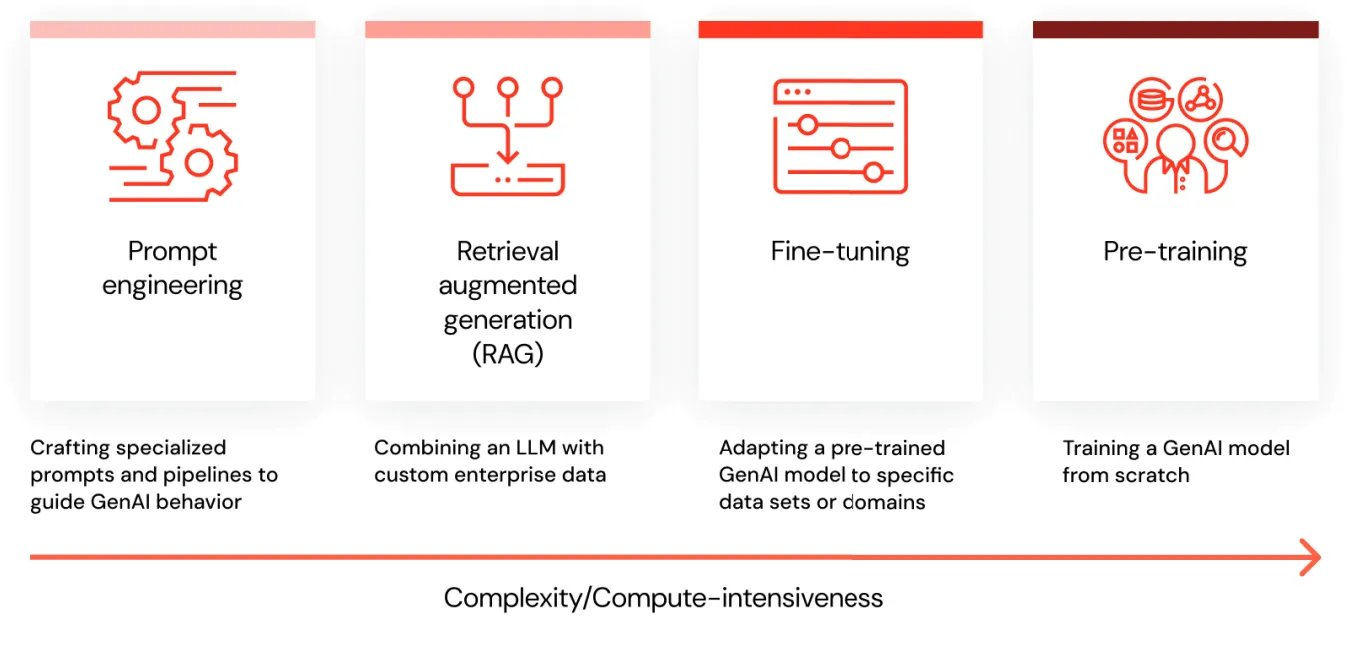

### Context
Entity extraction is an NLP technique that allows us to automatically extract specific data from naturally written text, such as news, emails, books, etc.
That data can then later be saved to a database, used for lookup or any other type of processing.

Classic entity extraction programs usually limit you to pre-defined classes, such as name, address, price, etc. or require you to provide many examples of types of entities you are interested in.
By using a LLM for entity extraction in most cases you are only required to specify what you need to extract in natural language. This gives you flexibility and accuracy in your queries while saving time by removing necessity of data labeling.

In addition, LLM entity extraction can be used to help you assemble a dataset to later create a customised solution for your use case, such as [Amazon Comprehend custom entity](https://docs.aws.amazon.com/comprehend/latest/dg/custom-entity-recognition.html) recognition.

## Setup


In [ ]:
# %pip install -U langchain-aws=='0.1.17'

In [ ]:
import json
import os
import sys

import boto3
import botocore

boto3_bedrock = boto3.client('bedrock-runtime')

## Configure langchain

We begin with instantiating the LLM. Here we are using Anthropic Claude v3 for text generation.

Note: It is possible to choose other models available with Bedrock. For example, you can replace the `model_id` as follows to change the model to Titan Text Premier. Make sure your account has access to the model you want to try out before trying this!

`llm = ChatBedrock(model_id="amazon.titan-text-premier-v1:0")`

Check [documentation](https://docs.aws.amazon.com/bedrock/latest/userguide/model-ids-arns.html) for Available text generation model Ids under Amazon Bedrock.

In [ ]:
from langchain_aws import ChatBedrock

llm = ChatBedrock(
    model_id="anthropic.claude-3-sonnet-20240229-v1:0",
    model_kwargs={
        "max_tokens": 200,
        "temperature": 0, # Using 0 to get reproducible results
        "stop_sequences": ["\n\nHuman:"]
    }
)

## Entity Extraction
Now that we have our LLM initialised, we can start extracting entities.

For this exercise we will pretend to be an online bookstore that receives questions and orders by email.
Our task would be to extract relevant information from the email to process the order.

Let's begin by taking a look at the sample email:

In [ ]:
from pathlib import Path

emails_dir = Path(".") / "emails"
with open(emails_dir / "00_treasure_island.txt") as f:
    book_question_email = f.read()

print(book_question_email)

### Basic approach

For basic cases we can directly ask the model to return the result.
Let's try extracting the name of the book.

In [ ]:
query = f"""
Given the email inside triple-backticks, please read it and analyse the contents.
If a name of a book is mentioned, return it, otherwise return nothing.

Email: ```
{book_question_email}
```

"""

messages = [
    (
        "system",
        "You are a helpful assistant that processes orders from a bookstore.",
    ),
    ("human", query),
]

In [ ]:
result = llm.invoke(messages)
print(result.content)

### Model specific prompts

While basic approach works, to achieve best results we recommend to customise your prompts for the particular model you will be using.
In this example we are using `anthropic.claude-3`, [prompt guide for which can be found here](https://docs.anthropic.com/claude/docs/introduction-to-prompt-design).

Here is the a more optimised prompt for Claude v3.

In [ ]:
prompt = """

Given the email provided, please read it and analyse the contents.
If a name of a book is mentioned, return it.
If no name is mentioned, return empty string.
The email will be given between <email></email> XML tags.

<email>
{email}
</email>

Return the name of the book between <book></book> XML tags.

"""

In [ ]:
query = prompt.format(email=book_question_email)
messages = [
    (
        "system",
        "You are a helpful assistant that processes orders from a bookstore.",
    ),
    ("human", query),
]
result = llm.invoke(messages).content
print(result)

To extract results easier, we can use a helper function:

In [ ]:
from bs4 import BeautifulSoup

def extract_by_tag(response: str, tag: str, extract_all=False) -> str | list[str] | None:
    soup = BeautifulSoup(response)
    results = soup.find_all(tag)
    if not results:
        return
        
    texts = [res.get_text() for res in results]
    if extract_all:
        return texts
    return texts[-1]

In [ ]:
extract_by_tag(result, "book")

We can check that our model doesn't return arbitrary results when no appropriate information is given (also know as 'hallucination'), by running our prompt on other emails.

In [ ]:
with open(emails_dir / "01_return.txt") as f:
    return_email = f.read()

print(return_email)

In [ ]:
query = prompt.format(email=return_email)
messages = [
    (
        "system",
        "You are a helpful assistant that processes orders from a bookstore.",
    ),
    ("human", query),
]
result = llm.invoke(query).content
print(result)

Using tags also allows us to extract multiple pieces of information at the same time and makes extraction much easier.
In the following prompt we will extract not just the book name, but any questions, requests and customer name.

In [ ]:
prompt = """

Human: Given email provided , please read it and analyse the contents.

Please extract the following information from the email:
- Any questions the customer is asking, return it inside <questions></questions> XML tags.
- The customer full name, return it inside <name></name> XML tags.
- Any book names the customer mentions, return it inside <books></books> XML tags.

If a particular bit of information is not present, return an empty string.
Make sure that each question can be understoon by itself, incorporate context if requred.
Each returned question should be concise, remove extra information if possible.
The email will be given between <email></email> XML tags.

<email>
{email}
</email>

Return each question inside <question></question> XML tags.
Return the name of each book inside <book></book> XML tags.

Assistant:"""

In [ ]:
query = prompt.format(email=book_question_email)
messages = [
    (
        "system",
        "You are a helpful assistant that processes orders from a bookstore.",
    ),
    ("human", query),
]
result = llm.invoke(query).content
print(result)

In [ ]:
extract_by_tag(result, "question", extract_all=True)

In [ ]:
extract_by_tag(result, "name")

In [ ]:
extract_by_tag(result, "book", extract_all=True)

## Conclusion

Entity extraction is a powerful technique using which you can extract arbitrary data using plain text descriptions.

This is particularly useful when you need to extract specific data which doesn't have clear structure. In such cases regex and other traditional extraction techniques can be very difficult to implement.

### Take aways
- Adapt this notebook to experiment with different models available through Amazon Bedrock such as Amazon Titan and AI21 Labs Jurassic models.
- Change the prompts to your specific usecase and evaluate the output of different models.
- Apply different prompt engineering principles to get better outputs. Refer to the prompt guide for your chosen model for recommendations, e.g. [here is the prompt guide for Claude](https://docs.anthropic.com/claude/docs/introduction-to-prompt-design).